## Comparison of different embedding types
In this notebook, we explore how different embeddings look like for the same content -  Presentation Slides. As presentation slides usually contain different modalities, like text, images or illustrations, it might be useful to know whether different types of embeddings are doing a better or worse job regarding the specific slide content. 
We will compare:
- pure text embeddings
- pure vision embeddings
- multi-modal embeddings

The presentation we use is designed for this specific task. Slides are adapted from the [Bio-image Data Science Lectures](https://zenodo.org/records/12623730) from Robert Haase (licensed under CC-BY 4.0). They are changed to explore whether specific changes (e.g. new background, layout, image resolution, contrast, text placement, design elements, language, ...) effect their ability to still group together related slides.

The PDF contains Slides with the following Adaptations:

**Slide 1**
- Original
- text only  - no slide number
- visual only
- original new design - no slide number

**Slide 2**
- Original
- text only
- visual only
- original new design  - no slide number

**Slide 3**
- Original
- text only
- visual only
- original new design  - no slide number
- original - german

**Slide 4**
- Original
- text only
- visual only
- original new design  - no slide number

**Slide 5**
- Original
- visual only
- original new design  - german
- original new design  - text rewritten
- original new design

In [1]:
from sentence_transformers import SentenceTransformer
from transformers import CLIPProcessor, CLIPModel
import pandas as pd
import torch
from PIL import Image
import requests
import os
from pdf_utilities import load_pdf, get_mixed_embedding, calculate_text_embeddings, process_slides

# Initialize models
text_model = SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

### Setting up the Model
Make sure you have set up the GITHUB_TOKEN. How this is done can be found in the [ReadMe](https://github.com/NFDI4BIOIMAGE/SlideInsight?tab=readme-ov-file#first).

In [2]:
from azure.ai.inference import ChatCompletionsClient
from azure.ai.inference.models import (
                SystemMessage,
                UserMessage,
                TextContentItem,
                ImageContentItem,
                ImageUrl,
                ImageDetailLevel,
            )
from azure.core.credentials import AzureKeyCredential 
        
        
endpoint = "https://models.inference.ai.azure.com"
token = os.environ["GITHUB_TOKEN"]
client = ChatCompletionsClient(
            endpoint=endpoint,
            credential=AzureKeyCredential(token),
        )

Now we have to load the PDF we want to feed in the workflow. Then we will extract all pdf slides as images and temporarily store them to display them later on. We also compute all thre different embedding types for each slide and save them in a dataframe.

In [3]:
pdf_path = "Test_Changes.pdf"  # Replace with your PDF path
slides = load_pdf(pdf_path)  # Load PDF as images

In [4]:
# Make a new directory to store the images in for processing
if not os.path.exists("images"):
    os.makedirs("images")

In [7]:
import os
from openai import OpenAI

token = os.environ["GITHUB_TOKEN"]
endpoint = "https://models.inference.ai.azure.com"
model_name = "gpt-4o"

client = OpenAI(
    base_url=endpoint,
    api_key=token,
)

response = client.chat.completions.create(
    messages=[
        {
            "role": "system",
            "content": "You are a helpful assistant.",
        },
        {
            "role": "user",
            "content": "What is the capital of France?",
        }
    ],
    temperature=1.0,
    top_p=1.0,
    max_tokens=1000,
    model=model_name
)

print(response.choices[0].message.content)

RateLimitError: Error code: 429 - {'error': {'code': 'RateLimitReached', 'message': 'Rate limit of 50 per 86400s exceeded for UserByModelByDay. Please wait 76868 seconds before retrying.', 'details': 'Rate limit of 50 per 86400s exceeded for UserByModelByDay. Please wait 76868 seconds before retrying.'}}

In [6]:
import pdfplumber

# Calculate the embeddings
text_embeddings = calculate_text_embeddings(pdf_path, text_model)
slide_embeddings = process_slides(slides, client, clip_processor, clip_model, text_model)

KeyboardInterrupt: 

In [6]:
# Create a DataFrame from visual and mixed-modal embeddings
df = pd.DataFrame(slide_embeddings)

# Add text embeddings to the DataFrame
df["text_embedding"] = df["slide_number"].map(text_embeddings)

#Show the DataFrame
df

,slide_number,visual_embedding,mixed_modal_embedding,text_embedding
0,0,"[0.007570520043373108, 0.514916181564331, -0.2...","[0.09811994, -0.60248655, 0.58528024, -0.09773...","[0.06354387, 0.13842154, 0.15972771, 0.0445101..."
1,1,"[0.21543118357658386, 0.3326210677623749, -0.1...","[0.19486555, -0.6431017, 1.148912, -0.43212312...","[0.090041704, 0.15044744, 0.15487127, 0.076248..."
2,2,"[0.14696401357650757, 0.4051353335380554, -0.3...","[0.048223652, -0.20447464, 0.14784002, -0.2919...","[0.21678813, 0.49195465, 0.015566356, 0.239418..."
3,3,"[0.2378602772951126, -0.19323937594890594, 0.1...","[0.20908661, -0.5270513, 1.0300199, -0.4494158...","[0.18867822, 0.040159266, 0.2643385, -0.001216..."
4,4,"[-0.33623725175857544, 0.3506889343261719, -0....","[0.07068585, -0.40263203, 1.0225686, -0.469437...","[-0.1623587, -0.2642947, 0.66837376, -0.694980..."
5,5,"[-0.1448518931865692, 0.29102176427841187, -0....","[-0.014602011, -0.6051216, 0.9945071, -0.25920...","[-0.15701555, -0.2631976, 0.67614114, -0.69411..."
6,6,"[-0.2185530811548233, 0.26123955845832825, 0.1...","[0.20465785, -0.5663693, 0.9635587, -0.5580863...","[0.12249113, 0.50097406, 0.21477973, 0.4813862..."
7,7,"[0.2906896770000458, 0.38915133476257324, -0.1...","[-0.107569225, -0.34216014, 0.7847591, -0.6580...","[-0.21556716, -0.17590277, 0.5248473, -0.33592..."
8,8,"[0.2371128499507904, 0.5161409378051758, 0.112...","[0.83086586, -0.40897563, 0.84360653, -0.53462...","[0.8595035, -0.755358, 0.7610082, -0.5979187, ..."
9,9,"[0.2295474410057068, 0.6171507835388184, -0.07...","[0.50187504, -0.75678164, 1.1307222, -0.553186...","[0.8526685, -0.7506917, 0.7696417, -0.6101845,..."


### Dimensionality Reduction
To display our results in 2D, we need to reduce the dimensionality of the embeddings. We are using the UMAP, that gives us 2 distinct numbers for each embedding, which can be visualized quite nicely in a dot plot. Dots close to each other have a very similar embedding (also in higher dimensions).

In [7]:
import numpy as np
import umap.umap_ as umap

# Initialize UMAP reducer
reducer = umap.UMAP(n_components=2, random_state=42)

# Initialize a dictionary to store UMAP results
umap_results = {}

# Apply UMAP to each embedding type
for embedding_type in ['text_embedding', 'visual_embedding', 'mixed_modal_embedding']:
    # Convert embeddings to a numpy array
    embeddings = np.array(df[embedding_type].tolist())
    
    # Apply UMAP
    umap_embeddings = reducer.fit_transform(embeddings)
    
    # Store results in the dictionary
    umap_results[embedding_type] = {
        'UMAP0': umap_embeddings[:, 0],
        'UMAP1': umap_embeddings[:, 1]
    }

# Create a new DataFrame to hold UMAP results for each embedding type
df_umap = df.copy()

for embedding_type, umap_data in umap_results.items():
    df_umap[f"{embedding_type}_UMAP0"] = umap_data['UMAP0']
    df_umap[f"{embedding_type}_UMAP1"] = umap_data['UMAP1']

# Output the DataFrame with UMAP results
df_umap(head)

/home/lea/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


,slide_number,visual_embedding,mixed_modal_embedding,text_embedding,text_embedding_UMAP0,text_embedding_UMAP1,visual_embedding_UMAP0,visual_embedding_UMAP1,mixed_modal_embedding_UMAP0,mixed_modal_embedding_UMAP1
0,0,"[0.007570520043373108, 0.514916181564331, -0.2...","[0.09811994, -0.60248655, 0.58528024, -0.09773...","[0.06354387, 0.13842154, 0.15972771, 0.0445101...",3.884172,3.004047,8.382152,5.897254,11.568286,-0.917459
1,1,"[0.21543118357658386, 0.3326210677623749, -0.1...","[0.19486555, -0.6431017, 1.148912, -0.43212312...","[0.090041704, 0.15044744, 0.15487127, 0.076248...",3.470467,2.769511,8.783420,6.322009,12.251889,-1.637598
2,2,"[0.14696401357650757, 0.4051353335380554, -0.3...","[0.048223652, -0.20447464, 0.14784002, -0.2919...","[0.21678813, 0.49195465, 0.015566356, 0.239418...",3.214019,3.214999,9.918159,6.156573,10.898928,-0.769541
3,3,"[0.2378602772951126, -0.19323937594890594, 0.1...","[0.20908661, -0.5270513, 1.0300199, -0.4494158...","[0.18867822, 0.040159266, 0.2643385, -0.001216...",3.875816,3.562415,7.821420,6.088531,11.881473,-1.314382
4,4,"[-0.33623725175857544, 0.3506889343261719, -0....","[0.07068585, -0.40263203, 1.0225686, -0.469437...","[-0.1623587, -0.2642947, 0.66837376, -0.694980...",4.886663,4.695495,7.614153,5.364134,12.434154,-2.476274
5,5,"[-0.1448518931865692, 0.29102176427841187, -0....","[-0.014602011, -0.6051216, 0.9945071, -0.25920...","[-0.15701555, -0.2631976, 0.67614114, -0.69411...",4.364706,4.644176,6.993926,5.316165,12.879553,-2.187406
6,6,"[-0.2185530811548233, 0.26123955845832825, 0.1...","[0.20465785, -0.5663693, 0.9635587, -0.5580863...","[0.12249113, 0.50097406, 0.21477973, 0.4813862...",2.497362,4.094010,8.315756,5.320569,12.488688,-3.030436
7,7,"[0.2906896770000458, 0.38915133476257324, -0.1...","[-0.107569225, -0.34216014, 0.7847591, -0.6580...","[-0.21556716, -0.17590277, 0.5248473, -0.33592...",4.592935,4.188367,7.254902,5.953313,12.932779,-2.630951
8,8,"[0.2371128499507904, 0.5161409378051758, 0.112...","[0.83086586, -0.40897563, 0.84360653, -0.53462...","[0.8595035, -0.755358, 0.7610082, -0.5979187, ...",6.667454,4.584389,8.202971,4.395423,13.662528,-0.489228
9,9,"[0.2295474410057068, 0.6171507835388184, -0.07...","[0.50187504, -0.75678164, 1.1307222, -0.553186...","[0.8526685, -0.7506917, 0.7696417, -0.6101845,...",6.566072,4.118064,8.620006,4.126990,12.585907,-0.245351


### Loading images
Now we load the images to display them next to the UMAP Embedding for each Embedding Type. By drawing a circle around the data points of interest, their corresponding Slide is displayed on the left. 

In [12]:
from PIL import Image

def get_images(df, folder = "images"):
    images = []
    for _, row in df.iterrows():
        slide_number = row['slide_number'] 
        img_path = os.path.join(folder, f"slide_{slide_number}.png")  # Construct the image path
        img = Image.open(img_path)  # Read the image
        images.append(img)
    return np.asarray(images)

In [13]:
images = get_images(df_umap)

In [14]:
import stackview
from skimage.io import imread

# Sliceplot for text_embedding
print("Sliceplot for text_embedding:")
stackview.sliceplot(
    df_umap,
    images,
    column_x="text_embedding_UMAP0",
    column_y="text_embedding_UMAP1",
    zoom_factor=0.25,
    zoom_spline_order=2
)


Sliceplot for text_embedding:


In [ ]:
import matplotlib.pyplot as plt

# UMAP Plot for text_embedding:
plt.figure(figsize=(10, 7))
plt.scatter(df['text_embedding_UMAP0'], df['text_embedding_UMAP1'], s=20, c='blue', alpha=0.6)  # Dot size and color
plt.title("UMAP Text Embedding", fontsize=16)
plt.xlabel("UMAP Dimension 1", fontsize=12)
plt.ylabel("UMAP Dimension 2", fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

In [15]:
# Sliceplot for visual_embedding
print("Sliceplot for visual_embedding:")
stackview.sliceplot(df_umap,images,column_x="visual_embedding_UMAP0",column_y="visual_embedding_UMAP1",zoom_factor=0.25,zoom_spline_order=2)

Sliceplot for visual_embedding:


In [ ]:
# UMAP Plot for visual_embedding:
plt.figure(figsize=(10, 7))
plt.scatter(df['visual_embedding_UMAP0'], df['visual_embedding_UMAP1'], s=20, c='blue', alpha=0.6)  # Dot size and color
plt.title("UMAP Visual Embedding", fontsize=16)
plt.xlabel("UMAP Dimension 1", fontsize=12)
plt.ylabel("UMAP Dimension 2", fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

In [16]:
# Sliceplot for mixed_modal_embedding
print("Sliceplot for mixed_modal_embedding:")
stackview.sliceplot(df_umap,images,column_x="mixed_modal_embedding_UMAP0",column_y="mixed_modal_embedding_UMAP1",zoom_factor=0.25,zoom_spline_order=2)

Sliceplot for mixed_modal_embedding:


You can choose which Embedding types you want to compare. Here, the mixed modal and text embeddign are compared.

In [17]:
# Sliceplot for comparing different models
print("Sliceplot for comparison:")
stackview.sliceplot(df_umap,images,column_x="mixed_modal_embedding_UMAP0",column_y="text_embedding_UMAP0",zoom_factor=0.25,zoom_spline_order=2)

Sliceplot for comparison:


In [ ]:
# UMAP Plot for mixed_modal_embedding:
plt.figure(figsize=(10, 7))
plt.scatter(df['mixed_modal_embedding_UMAP0'], df['mixed_modal_embedding_UMAP1'], s=20, c='blue', alpha=0.6)  # Dot size and color
plt.title("UMAP Mixed Modal Embedding", fontsize=16)
plt.xlabel("UMAP Dimension 1", fontsize=12)
plt.ylabel("UMAP Dimension 2", fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

In [18]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import seaborn as sns
import matplotlib.pyplot as plt

# Function to compute pairwise distance matrices
def compute_similarity_matrices(embeddings_df, embedding_types, metric="cosine"):
    similarity_matrices = {}
    for embedding_type in embedding_types:
        embeddings = np.array(embeddings_df[embedding_type].tolist())
        if metric == "cosine":
            similarity_matrix = cosine_similarity(embeddings)
        elif metric == "euclidean":
            similarity_matrix = -euclidean_distances(embeddings)  # Negate for consistency with similarity
        else:
            raise ValueError("Unsupported metric. Use 'cosine' or 'euclidean'.")
        similarity_matrices[embedding_type] = similarity_matrix
    return similarity_matrices

# Function to create a "perfect" similarity matrix
def create_perfect_similarity(num_slides, groups):
    perfect_similarity = np.zeros((num_slides, num_slides))
    for group in groups:
        for i in group:
            for j in group:
                perfect_similarity[i, j] = 1
    return perfect_similarity

# Function to visualize similarity matrices
def visualize_similarity_matrices(similarity_matrices, perfect_similarity=None):
    # Add the perfect similarity matrix if provided
    if perfect_similarity is not None:
        similarity_matrices["Perfect"] = perfect_similarity
    
    # Create subplots
    fig, axes = plt.subplots(1, len(similarity_matrices), figsize=(20, 5))  # Adjust width for extra plot
    for ax, (embedding_type, matrix) in zip(axes, similarity_matrices.items()):
        sns.heatmap(matrix, ax=ax, cmap="coolwarm", xticklabels=False, yticklabels=False, cbar=True, square=True)
        ax.set_title(f"{embedding_type.capitalize()} Similarity")
    plt.tight_layout()
    plt.show()

### Similarity Matrices
According to the PDF, The matrices should somehow display the pattern seen in the 'Perfect Similarity Matrix'. Those were the groups of Slides, I have edited to look different or show only text/visual content. As a similarity measurement the cosine similarity is used. It computes the difference between two vector representations. Slides, that were adapted from the same slide, should (in a perfect szenario) have quite similar embeddings and therefore a high cosine similarity, that would result in those red boxes. The different embedding types show very different patterns of similarity.

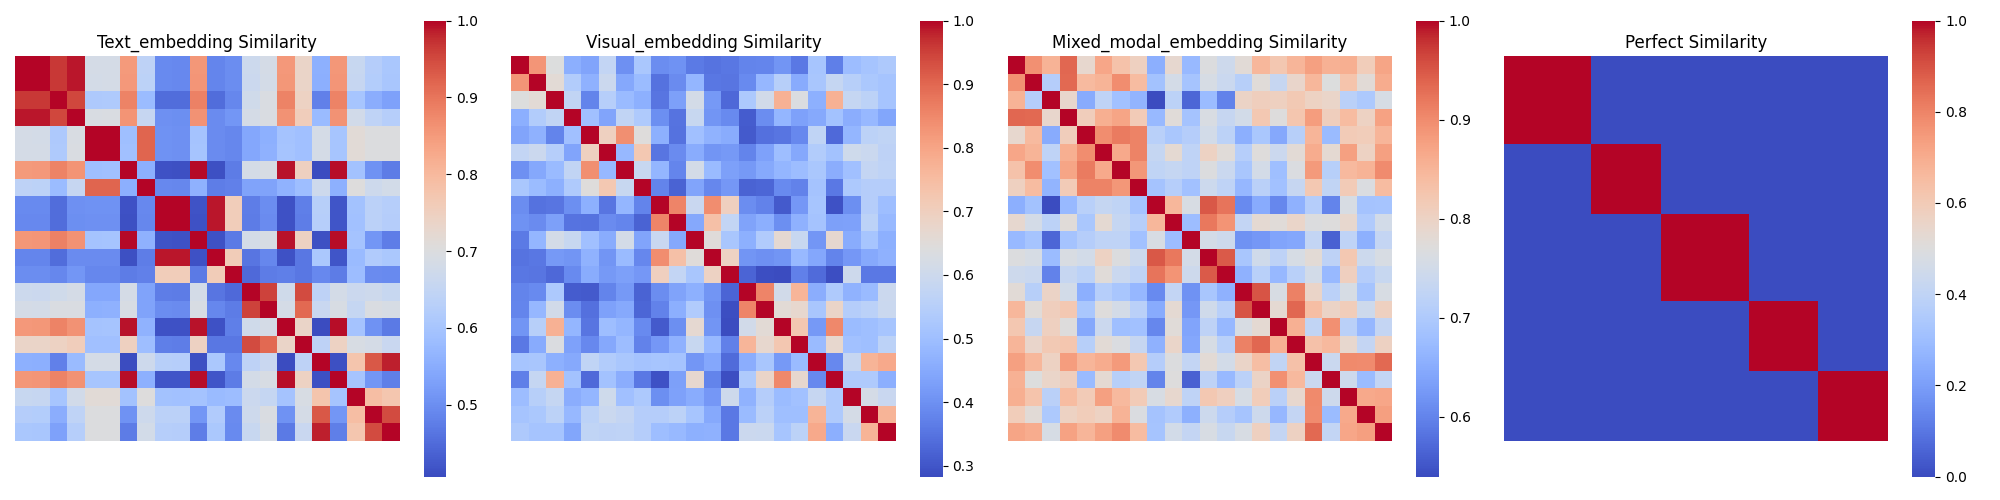

In [19]:
# Compute similarity matrices for all embedding types
embedding_types = ["text_embedding", "visual_embedding", "mixed_modal_embedding"]
similarity_matrices = compute_similarity_matrices(df, embedding_types)

# Define slide groups (depends on your PDF!)
groups = [
    range(0, 5),   # Slides 1-5 (0-indexed: 0-4)
    range(5, 9),   # Slides 6-9 (0-indexed: 5-8)
    range(9, 14),  # Slides 10-14 (0-indexed: 9-13)
    range(14, 18), # Slides 15-18 (0-indexed: 14-17)
    range(18, 22), # Slides 19-22 (0-indexed: 18-21)
]

# Create the perfect similarity matrix
num_slides = len(slides)
perfect_similarity_matrix = create_perfect_similarity(num_slides, groups)

# Visualize the similarity matrices, including the perfect similarity matrix
visualize_similarity_matrices(similarity_matrices, perfect_similarity=perfect_similarity_matrix)


### UMAP Differences
Now, we compute and visualize the pairwise differences in UMAP embeddings between three embedding types: text, visual, and mixed-modal. We use the L2 norm differences between these embeddings for each slide and display the results as side-by-side bar charts. Vertical lines mark predefined boundaries (page sets) to highlight changes across different slides. For the Testing PDF we can clearly see, that Text and Visual Embeddings are the most similar ones when compared to each other, whereas visual/text and mixed modal have the highest difference.

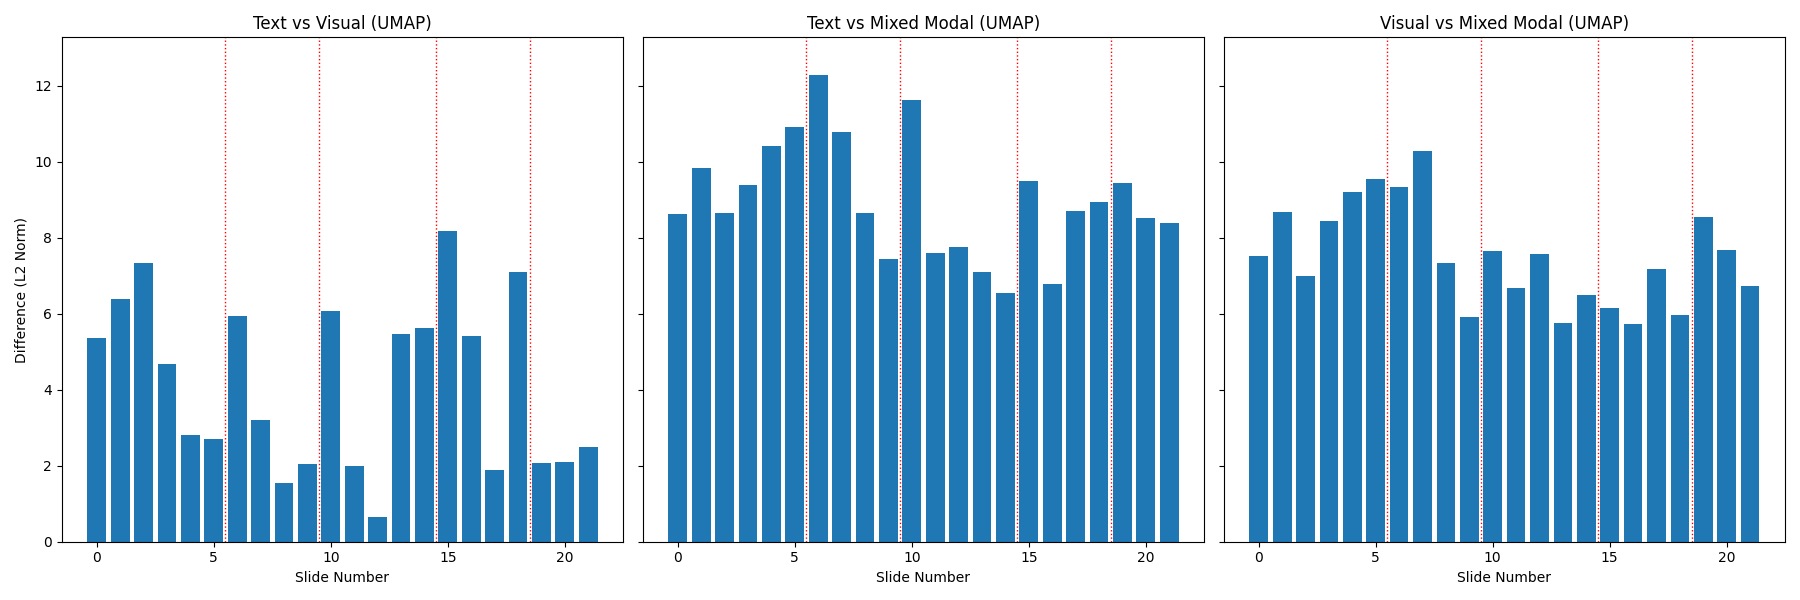

In [20]:
# Function to compute and visualize UMAP embedding differences explicitly for three embedding types
def visualize_umap_differences_explicit(embeddings_df):
    # Extract UMAP columns for each embedding type
    text_umap = embeddings_df[["text_embedding_UMAP0", "text_embedding_UMAP1"]].to_numpy()
    visual_umap = embeddings_df[["visual_embedding_UMAP0", "visual_embedding_UMAP1"]].to_numpy()
    mixed_modal_umap = embeddings_df[["mixed_modal_embedding_UMAP0", "mixed_modal_embedding_UMAP1"]].to_numpy()

    # Compute differences in UMAP space
    text_vs_visual = np.linalg.norm(text_umap - visual_umap, axis=1)
    text_vs_mixed_modal = np.linalg.norm(text_umap - mixed_modal_umap, axis=1)
    visual_vs_mixed_modal = np.linalg.norm(visual_umap - mixed_modal_umap, axis=1)

    # List of x-positions for vertical lines, indicating the beginning of a new Page-Set
    vertical_lines = [4.5, 8.5, 13.5, 17.5]

    # Determine the same y-axis scale for all plots
    max_difference = max(
        np.max(text_vs_visual), 
        np.max(text_vs_mixed_modal), 
        np.max(visual_vs_mixed_modal)
    ) + 1

    # Create a figure with 3 subplots side by side
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    # Plot differences: Text vs Visual
    axes[0].bar(embeddings_df["slide_number"], text_vs_visual)
    for line in vertical_lines:
        axes[0].axvline(x=line, color='red', linestyle='dotted', linewidth=1)
    axes[0].set_ylim(0, max_difference)
    axes[0].set_title("Text vs Visual (UMAP)")
    axes[0].set_xlabel("Slide Number")
    axes[0].set_ylabel("Difference (L2 Norm)")

    # Plot differences: Text vs Mixed Modal
    axes[1].bar(embeddings_df["slide_number"], text_vs_mixed_modal)
    for line in vertical_lines:
        axes[1].axvline(x=line, color='red', linestyle='dotted', linewidth=1)
    axes[1].set_ylim(0, max_difference)
    axes[1].set_title("Text vs Mixed Modal (UMAP)")
    axes[1].set_xlabel("Slide Number")

    # Plot differences: Visual vs Mixed Modal
    axes[2].bar(embeddings_df["slide_number"], visual_vs_mixed_modal)
    for line in vertical_lines:
        axes[2].axvline(x=line, color='red', linestyle='dotted', linewidth=1)
    axes[2].set_ylim(0, max_difference)
    axes[2].set_title("Visual vs Mixed Modal (UMAP)")
    axes[2].set_xlabel("Slide Number")

    # Adjust layout for better visualization
    plt.tight_layout()
    plt.show()

# Visualize UMAP embedding differences explicitly for three embedding types
visualize_umap_differences_explicit(df_umap)

To also numerically prove that, we can now compute the average difference across all slides for the different embedding types.

In [21]:
def compute_average_normalized_difference(embeddings_df):
    # Extract UMAP columns for each embedding type
    text_umap = embeddings_df[["text_embedding_UMAP0", "text_embedding_UMAP1"]].to_numpy()
    visual_umap = embeddings_df[["visual_embedding_UMAP0", "visual_embedding_UMAP1"]].to_numpy()
    mixed_modal_umap = embeddings_df[["mixed_modal_embedding_UMAP0", "mixed_modal_embedding_UMAP1"]].to_numpy()

    # Compute differences in UMAP space
    text_vs_visual = np.linalg.norm(text_umap - visual_umap, axis=1)
    text_vs_mixed_modal = np.linalg.norm(text_umap - mixed_modal_umap, axis=1)
    visual_vs_mixed_modal = np.linalg.norm(visual_umap - mixed_modal_umap, axis=1)

    # Compute average differences for each pair of models
    avg_text_vs_visual = np.mean(text_vs_visual) / len(embeddings_df)
    avg_text_vs_mixed_modal = np.mean(text_vs_mixed_modal) / len(embeddings_df)
    avg_visual_vs_mixed_modal = np.mean(visual_vs_mixed_modal) / len(embeddings_df)

    # Store results in a dictionary
    differences = {
        "Text vs Visual": avg_text_vs_visual,
        "Text vs Mixed Modal": avg_text_vs_mixed_modal,
        "Visual vs Mixed Modal": avg_visual_vs_mixed_modal,
    }

    # Find the model pair with the highest normalized average difference
    highest_difference_pair = max(differences, key=differences.get)

    print("Normalized Average Differences:")
    for pair, difference in differences.items():
        print(f"{pair}: {difference:.4f}")

    print(f"\nHighest Difference Pair: {highest_difference_pair} with value {differences[highest_difference_pair]:.4f}")

# Compute and print normalized average differences
compute_average_normalized_difference(df_umap)


Normalized Average Differences:
Text vs Visual: 0.1880
Text vs Mixed Modal: 0.4087
Visual vs Mixed Modal: 0.3417

Highest Difference Pair: Text vs Mixed Modal with value 0.4087


### Optionally: Deleting the Images
Here is how you could easily remove the Image folder again:

In [22]:
import shutil

# Specify the folder path
folder_path = "images"

try:
    # Delete the entire folder and its contents
    shutil.rmtree(folder_path)
    print(f"Deleted the folder: {folder_path}")
except Exception as e:
    print(f"Error deleting folder {folder_path}: {e}")

Deleted the folder: images
